GMM for PHD distribution
========================

In [164]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker

import plotly.express as px


from skimage import registration

from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV as GS

from scipy import ndimage
from scipy import signal
from scipy import stats


In [88]:
df4 = pd.read_csv('phd_gmm_cdf_data4.csv')
df6 = pd.read_csv('phd_gmm_cdf_data6.csv')

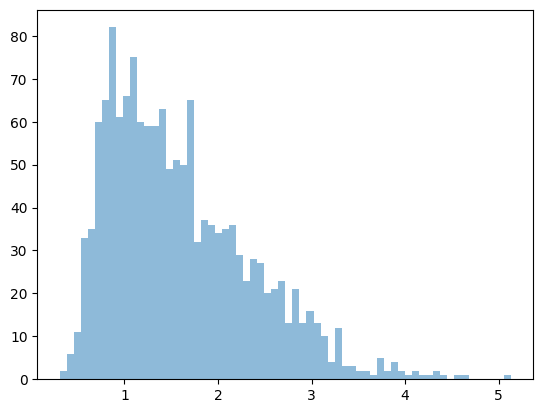

In [102]:
plt.hist(df4[['Membrane_Value']].to_numpy(), fill='red', alpha=.5, bins=64)
# plt.hist(df6[['Membrane_Value']].to_numpy(), fill='blue', alpha=.5)
plt.show()

## GMM for PM

### n estimation

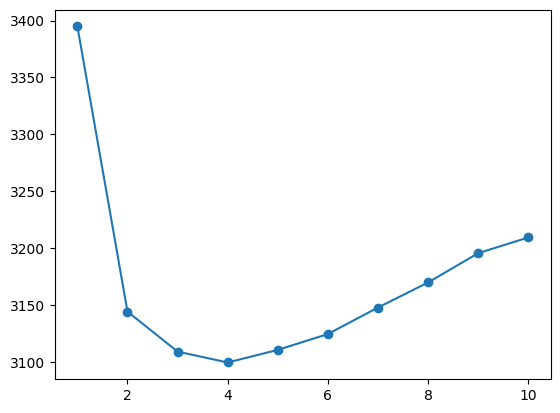

In [158]:
# https://stackoverflow.com/questions/55187037/how-can-i-do-a-histogram-with-1d-gaussian-mixture-with-sklearn
pm_arr = df4[['Membrane_Value']].to_numpy()
pm_arr.shape

pm_bic = []
pm_mod = []

for n_g in range(1,11):
    gmm = GMM(n_components = n_g, max_iter=1000, random_state=0, covariance_type = 'full')
    gmm.fit(pm_arr).predict(pm_arr)
    pm_bic.append(gmm.bic(pm_arr))
    pm_mod.append([list(gmm.means_), list(gmm.covariances_)])

plt.scatter(x=range(1,11), y=pm_bic)
plt.plot(range(1,11), pm_bic)

### nice plot

In [119]:
n_optimal = 4
gmm_optimal = GMM(n_components=n_optimal, max_iter=1000, random_state=0, covariance_type = 'full')
gmm_optimal.fit(pm_arr).predict(pm_arr)

means = gmm_optimal.means_
covs = gmm_optimal.covariances_
w = gmm_optimal.weights_

x = np.arange(0, 5.5, 0.01)
y0 = stats.norm.pdf(x, float(means[0][0]), np.sqrt(float(covs[0][0][0])))*w[0]
y1 = stats.norm.pdf(x, float(means[1][0]), np.sqrt(float(covs[1][0][0])))*w[1]
y2 = stats.norm.pdf(x, float(means[2][0]), np.sqrt(float(covs[2][0][0])))*w[2]
y3 = stats.norm.pdf(x, float(means[3][0]), np.sqrt(float(covs[3][0][0])))*w[3]


Text(0, 0.5, 'Density')

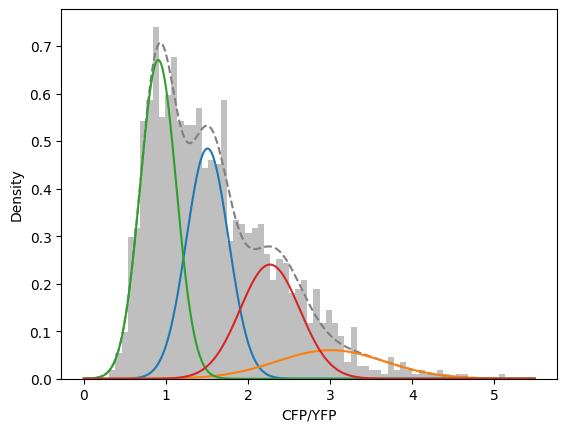

In [125]:
plt.hist(pm_arr, bins=64, density=True, color='black', alpha=.25)
plt.plot(x, y0+y1+y2+y3, ls='dashed', color='grey')
plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

plt.xlabel("CFP/YFP")
plt.ylabel("Density")

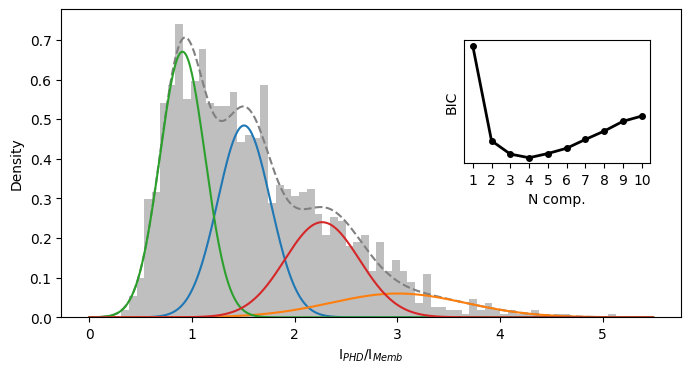

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(pm_arr, bins=64, density=True, color='black', alpha=.25)
ax.plot(x, y0+y1+y2+y3, ls='dashed', color='grey')
ax.plot(x, y0)
ax.plot(x, y1)
ax.plot(x, y2)
ax.plot(x, y3)

axins = ax.inset_axes([0.65, 0.5, 0.3, 0.4])
axins.plot(range(1,11), pm_bic, color='black', marker='o', linewidth=2, markersize=4)
axins.set_xlabel('N comp.')
axins.set_ylabel('BIC')
axins.xaxis.set_major_locator(ticker.FixedLocator(range(1,11)))
axins.tick_params(left=False, labelleft=False)


plt.xlabel(r"I$_{PHD}$/I$_{Memb}$")
plt.ylabel("Density")

plt.show()

### v2

In [82]:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html

pm_param_gtid = {"n_components": range(1, 15),
                 "covariance_type": ["spherical", "tied", "diag", "full"]}

def gmm_bic(estimator, X):
    return estimator.bic(X)

pm_grid_search = GS(GMM(covariance_type='tied'), param_grid=pm_param_gtid, scoring=gmm_bic)
pm_grid_search.fit(pm_arr)

GridSearchCV(estimator=GaussianMixture(covariance_type='tied'),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 15)},
             scoring=<function gmm_bic at 0x7a50de552c10>)

In [84]:
df_pm_gmm = pd.DataFrame(pm_grid_search.cv_results_)[["param_n_components", "mean_test_score", "param_covariance_type"]]
df_pm_gmm["mean_test_score"] = -df_pm_gmm["mean_test_score"]
df_pm_gmm = df_pm_gmm.rename(
    columns={"mean_test_score": "BIC_score"})
df_pm_gmm.sort_values(by="BIC_score")

,param_n_components,BIC_score,param_covariance_type
40,13,-25788.349137,diag
13,14,-22197.801640,spherical
55,14,-21618.160913,full
12,13,-21486.475949,spherical
41,14,-21271.561114,diag
38,11,-18950.530765,diag
53,12,-17916.344502,full
54,13,-17737.847562,full
11,12,-17657.714684,spherical
39,12,-17456.300479,diag


In [85]:
fig = px.line(df_pm_gmm, x='param_n_components', color='param_covariance_type', y='BIC_score', title='PM GMM', markers=True)
fig.show()